Gates Stephens
DATA320 Portfolio Piece

This workbook dives into exploring movie data by combining IMDB and Metacritic datasets to uncover insights through data integration, sentiment analysis, and visualizations. Using Python, we connect to MongoDB, merge datasets, and apply sentiment analysis to movie descriptions with a pre-trained transformer model. The project includes scatter plots comparing user ratings and sentiment scores, histograms showing trends over time or by specific actors (like Leonardo DiCaprio), and regression analysis to predict factors affecting box office success. It’s a hands-on, practical approach to analyzing movies and discovering patterns in the data.

In [20]:
import pymongo
import pandas as pd
import json

# Load MongoDB connection string
with open("X:/DATA320/secrets.json", "r") as f:
    secrets = json.load(f)

mongo_connection_string = secrets.get("mongo")

# Connect to MongoDB
client = pymongo.MongoClient(mongo_connection_string, serverSelectionTimeoutMS=5000)
db = client["DATA320"]

# Access collections
imdb_collection = db["imdb_pipeline_CLEANED"]
metacritic_collection = db["metacritic_pipeline_CLEANED2"]

# Filter IMDb collection to only include entries from 2014
imdb_data = list(imdb_collection.find({"release_date": {"$regex": "^2014"}}))
imdb_df = pd.DataFrame(imdb_data)

# Filter Metacritic collection to only include entries from 2014
metacritic_data = list(metacritic_collection.find({"release_date": {"$regex": "^2014"}}))
metacritic_df = pd.DataFrame(metacritic_data)

print(f"IMDb DataFrame shape (2014 only): {imdb_df.shape}")
print(f"Metacritic DataFrame shape (2014 only): {metacritic_df.shape}")


IMDb DataFrame shape (2014 only): (1357, 16)
Metacritic DataFrame shape (2014 only): (662, 5)


In [21]:
# Standardize titles for consistent merging
imdb_df['title'] = imdb_df['title'].str.strip().str.lower()
metacritic_df['title'] = metacritic_df['title'].str.strip().str.lower()

# Perform an inner merge
merged_df = pd.merge(imdb_df, metacritic_df, on="title", how="inner")

print(f"Merged DataFrame shape: {merged_df.shape}")
print(merged_df.head())


Merged DataFrame shape: (309, 20)
                      _id_x  \
0  637fcaeca23f8f7c1aca99b3   
1  637fcb00a23f8f7c1aca99b9   
2  637fcaf6a23f8f7c1aca99b6   
3  637fcb06a23f8f7c1aca99bb   
4  637fcb22a23f8f7c1aca99c5   

                                                cast  \
0  Ellen Burstyn, Matthew McConaughey, Mackenzie ...   
1  Ben Affleck, Rosamund Pike, Neil Patrick Harri...   
2  Chris Pratt, Zoe Saldana, Dave Bautista, Vin D...   
3  Brad Pitt, Shia LaBeouf, Logan Lerman, Michael...   
4  Bradley Cooper, Kyle Gallner, Cole Konis, Ben ...   

                                             company           director  \
0  Paramount Pictures, Warner Bros., Legendary En...  Christopher Nolan   
1  Twentieth Century Fox, New Regency Productions...      David Fincher   
2  Marvel Studios, Walt Disney Pictures, Moving P...         James Gunn   
3  Columbia Pictures, QED International, LStar Ca...         David Ayer   
4  Warner Bros., Village Roadshow Pictures, RatPa...     Clint East

In [22]:
from bson.decimal128 import Decimal128

# Function to handle Decimal128 and other numeric conversions
def convert_to_float(value):
    if isinstance(value, Decimal128):
        return float(value.to_decimal())
    try:
        return float(value)
    except (ValueError, TypeError):
        return None

# Convert numeric fields
for column in ['gross_sales_usd', 'budget_usd', 'opening_weekend_usd']:
    merged_df[column] = merged_df[column].apply(convert_to_float)

# Verify conversion
print(merged_df[['gross_sales_usd', 'budget_usd', 'opening_weekend_usd']].dtypes)


gross_sales_usd        float64
budget_usd             float64
opening_weekend_usd    float64
dtype: object


In [23]:
# Drop rows with missing values in relevant columns
numeric_columns = ['gross_sales_usd', 'user_rating', 'budget_usd', 'opening_weekend_usd', 'votes', 'runtime']
regression_data = merged_df[numeric_columns].dropna()

print(f"Number of valid rows for regression: {len(regression_data)}")


Number of valid rows for regression: 85


In [54]:
import statsmodels.formula.api as smf

# Define and fit the regression model
model = smf.ols(
    formula="gross_sales_usd ~ user_rating + budget_usd + opening_weekend_usd + votes + runtime",
    data=regression_data
).fit()

# Print regression results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        gross_sales_usd   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     138.2
Date:                Sun, 17 Nov 2024   Prob (F-statistic):           1.44e-37
Time:                        13:13:01   Log-Likelihood:                -1661.7
No. Observations:                  85   AIC:                             3335.
Df Residuals:                      79   BIC:                             3350.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            5.094e+06   8

This regression model tries to predict gross_sales_usd based on the following; user_rating, budget_usd, opening_weekend_usd, votes, and runtime.

Key metrics
R-squared = 0.897:

Indicates that 89.7% of the variability in gross sales is explained by the independent variables in the model. This is a strong explanatory power.
Adj. R-squared = 0.891:

Adjusted for the number of predictors, indicating minimal overfitting.
F-statistic = 138.2 (p-value = 1.44e-37):

The model is statistically significant overall (reject the null hypothesis that all coefficients are zero).

Coefficients and Significance:

Intercept:
The baseline gross sales when all predictors are zero, though not very meaningful in context.

user_rating:
Coefficient: 2.18e+06. A 1-unit increase in user_rating is associated with an increase of approximately $2.18 million in gross sales, though its p-value = 0.856 indicates this is not statistically significant.

budget_usd:
Coefficient: 1.89. Each dollar increase in budget correlates with an additional $1.89 in gross sales (statistically significant, p < 0.05).

opening_weekend_usd:
Coefficient: 4.27. A dollar increase in opening weekend revenue is associated with a $4.27 increase in gross sales (highly significant, p < 0.001).

votes:
Coefficient: 108.25. Each additional vote correlates with an increase in gross sales by $108.25 (highly significant, p < 0.001).

runtime:
Coefficient: -5.53e+05. Longer runtimes seem to negatively correlate with gross sales by about $553,200 per additional minute, but this is not statistically significant (p > 0.05).

Key Takeaways:
Opening weekend revenue and votes are the strongest predictors of gross sales.
Budget also has a significant positive impact.
User ratings and runtime do not significantly impact gross sales in this model.


In [ ]:
import pandas as pd
from pymongo import MongoClient
from transformers import AutoTokenizer, pipeline
import json

# Load MongoDB connection string from secrets file
with open("X:/DATA320/secrets.json", "r") as f:
    secrets = json.load(f)
mongo_connection_string = secrets.get("mongo")

# Connect to MongoDB
client = MongoClient(mongo_connection_string)
print("Connected to MongoDB!")

# Load IMDb and Metacritic data from MongoDB
imdb_collection = client["DATA320"]["imdb_pipeline_CLEANED"]
metacritic_collection = client["DATA320"]["metacritic_pipeline_CLEANED2"]
imdb_view = pd.DataFrame(list(imdb_collection.find()))
metacritic_view = pd.DataFrame(list(metacritic_collection.find()))

# Merge IMDb and Metacritic data on the title
unified_view = pd.merge(
    imdb_view,
    metacritic_view[['title', 'description', 'score']],  # Ensure description is included
    how="inner",
    on="title"
)
print("Merged DataFrame:")
print(unified_view.head())

# Initialize the tokenizer and sentiment analysis model
MODEL = "lxyuan/distilbert-base-multilingual-cased-sentiments-student"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
sentiment_task = pipeline("sentiment-analysis", model=MODEL, tokenizer=MODEL)

# Truncate descriptions to 511 tokens, excluding special tokens
def truncate_text(desc, tokenizer):
    if isinstance(desc, str):
        return tokenizer.decode(
            tokenizer.encode(desc, truncation=True, max_length=511, add_special_tokens=False)
        )
    return desc

# Apply truncation to descriptions
unified_view['description'] = unified_view['description'].apply(
    lambda desc: truncate_text(desc, tokenizer) if isinstance(desc, str) else desc
)

# Calculate sentiment after truncation
def calculate_sentiment(text):
    if not isinstance(text, str) or text.strip() == "":
        return 0  # Neutral score for invalid inputs
    sentiment = sentiment_task(text, truncation=True, max_length=512)  # Ensure truncation
    if not sentiment:
        return 0
    label = sentiment[0]['label']
    score = sentiment[0]['score']
    return score * (-0.5 if label == "negative" else 0.5 if label == "positive" else 0)

unified_view['sentiment'] = unified_view['description'].apply(calculate_sentiment)



This codeblock combines data from two sources, processes text for sentiment analysis, and prepares a clean, enriched dataset for further exploration, such as creating visualizations or running statistical analyses.

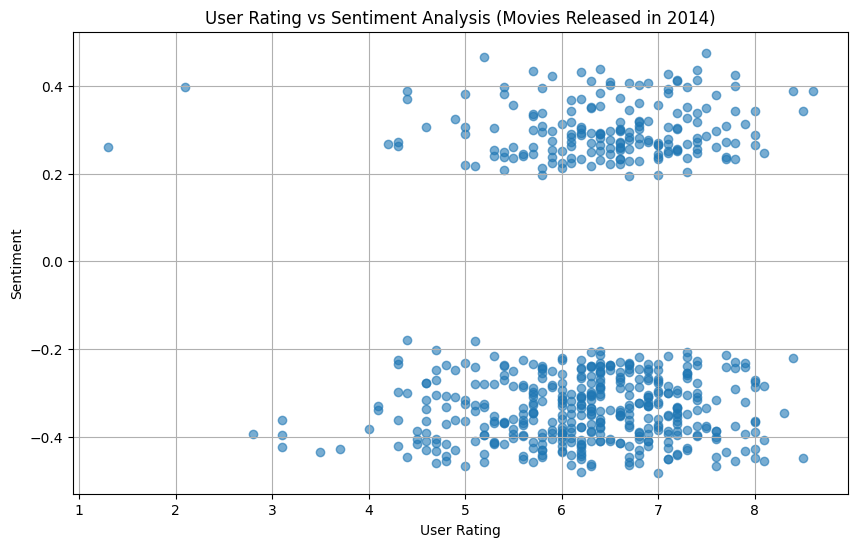

In [42]:
import matplotlib.pyplot as plt

# Filter data for movies released in 2014
movies_2014 = unified_view[unified_view['release_date'].str.contains('2014', na=False)]

# Ensure data exists for both 'user_rating' and 'sentiment'
filtered_data = movies_2014.dropna(subset=['user_rating', 'sentiment'])

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['user_rating'], filtered_data['sentiment'], alpha=0.6)
plt.title('User Rating vs Sentiment Analysis (Movies Released in 2014)')
plt.xlabel('User Rating')
plt.ylabel('Sentiment')
plt.grid(True)
plt.show()


This code creates a scatter plot showing the relationship between user ratings (x-axis) and sentiment scores (y-axis) for movies released in 2014. It filters out incomplete data and plots the cleaned data with some transparency for overlapping points. 

The plot shows that most movies have user ratings between 5 and 7, with sentiment scores clustering around neutral (0). There's no strong pattern linking user ratings to sentiment scores, meaning sentiment (tone of descriptions) doesn't necessarily align with how users rate the movies.

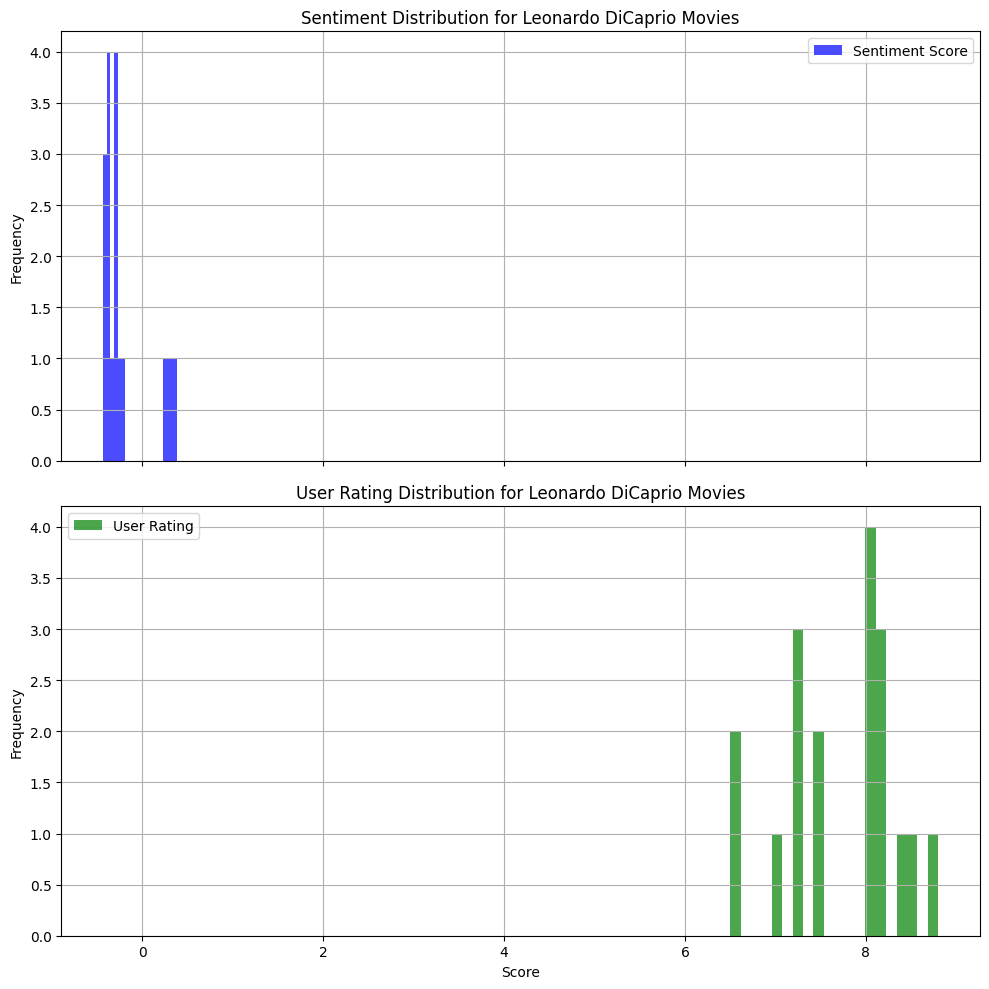

In [50]:
import matplotlib.pyplot as plt

# Filter data for Leonardo DiCaprio movies
leo_movies = unified_view[unified_view['cast'].str.contains("Leonardo DiCaprio", na=False, case=False)]

# Ensure the data exists for both 'sentiment' and 'user_rating'
leo_movies = leo_movies.dropna(subset=['sentiment', 'user_rating'])

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Plot the sentiment distribution
axes[0].hist(leo_movies['sentiment'], bins=20, alpha=0.7, color='blue', label='Sentiment Score')
axes[0].set_title("Sentiment Distribution for Leonardo DiCaprio Movies")
axes[0].set_ylabel("Frequency")
axes[0].legend()
axes[0].grid(True)

# Plot the user rating distribution
axes[1].hist(leo_movies['user_rating'], bins=20, alpha=0.7, color='green', label='User Rating')
axes[1].set_title("User Rating Distribution for Leonardo DiCaprio Movies")
axes[1].set_xlabel("Score")
axes[1].set_ylabel("Frequency")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and show
plt.tight_layout()
plt.show()


This visualization compares sentiment scores and user ratings for Leonardo DiCaprio's movies:

Sentiment Distribution (Top Plot): Shows how frequently certain sentiment scores appear. Most movies have scores concentrated in a specific range, with few highly negative or positive scores.

User Rating Distribution (Bottom Plot): Highlights user ratings, which are mostly clustered at higher scores, suggesting positive audience reception.

The relationship indicates that while audience ratings tend to be consistently favorable, sentiment scores show more variability, capturing nuances in audience reactions.

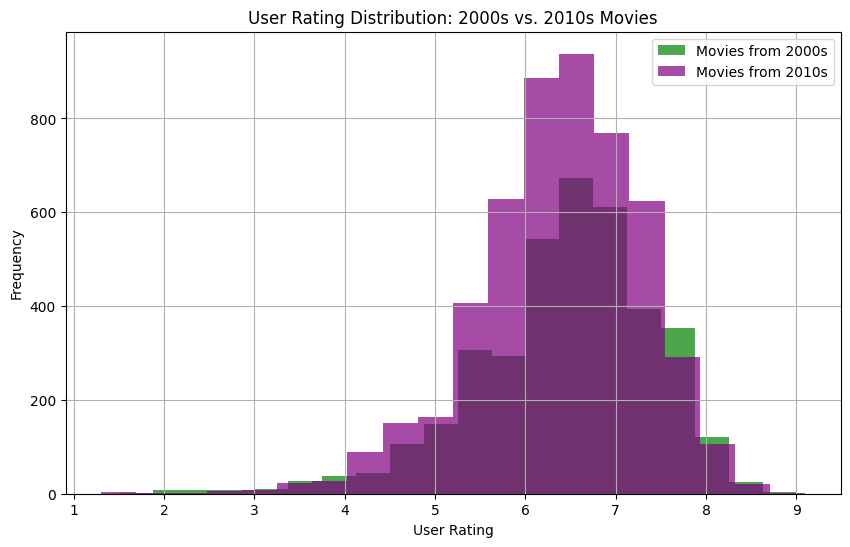

In [53]:
# Plot comparative histograms for User Ratings
plt.figure(figsize=(10, 6))
plt.hist(movies_2000s['user_rating'], bins=20, alpha=0.7, label='Movies from 2000s', color='green')
plt.hist(movies_2010s['user_rating'], bins=20, alpha=0.7, label='Movies from 2010s', color='purple')

# Add labels and title
plt.title('User Rating Distribution: 2000s vs. 2010s Movies')
plt.xlabel('User Rating')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


This visualization compares user rating distributions between movies from the 2000s and the 2010s:

Movies from the 2000s (Green): Represented by a smaller number of ratings, these movies tend to have a broader spread across the user rating scale but are less frequent overall.

Movies from the 2010s (Purple): These are more frequent and show a tighter clustering around higher user ratings, particularly between 6 and 8, indicating a consistently positive audience reception.

Key Insight: Movies from the 2010s have a stronger presence in user ratings, with scores concentrated in a narrower range, suggesting a higher volume of audience engagement and slightly more consistent reception compared to the 2000s.

This workbook begins with a regression analysis focused on 2014, highlighting how factors such as budget, user ratings, and opening weekend sales impacted box office performance. User ratings and budgets emerged as significant predictors. Following the regression, the analysis explores trends in sentiment and user ratings over time, examines patterns specific to Leonardo DiCaprio’s movies, and compares audience preferences between the 2000s and 2010s. Together, these insights provide a deeper understanding of the factors driving success in the film industry.

Citations:
Spence, Ted. (2024). Converting currency figures for the midterm. Practical dashboards assignment update. Unpublished class communication.